#Objective
Predict the number of furniture items sold based on product attributes such as productTitle, originalPrice, price, and tagText.

# Data Preprocessing

In [68]:
# Importing required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [69]:
# Reading Data
df = pd.read_csv('ecommerce_furniture_dataset_2024.csv')
df.head()

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   productTitle   2000 non-null   object
 1   originalPrice  487 non-null    object
 2   price          2000 non-null   object
 3   sold           2000 non-null   int64 
 4   tagText        1997 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


In [71]:
df.describe()

,sold
count,2000.000000
mean,23.493500
std,254.094061
min,0.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,10000.000000


In [72]:
# Remove duplicates
df = df.drop_duplicates()

In [73]:
# Handle missing values (drop)
df.isnull().sum()

,0
productTitle,0
originalPrice,1436
price,0
sold,0
tagText,2


In [74]:
# Dropping null rows (2)
df.loc[:,'tagText'] = df['tagText'].dropna()

# Dropping column due to 71.8% of missing values
df = df.drop('originalPrice', axis=1)

In [75]:
# Converting column from string to float
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

In [76]:
df['tagText'].value_counts()

,count
tagText,
Free shipping,1789
+Shipping: $5.09,9
+Shipping: $239.64,2
+Shipping: $80.21,2
+Shipping: $94.92,2
...,...
+Shipping: $134.27,1
+Shipping: $151.69,1
+Shipping: $41.93,1


In [77]:
df['tagText'] = df['tagText'].apply(lambda x: x if x in ['Free shipping', '+Shipping: $5.09'] else 'others')
df['tagText'].value_counts()

,count
tagText,
Free shipping,1789
others,108
+Shipping: $5.09,9


# Exploratory Data Analysis (EDA)

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
# Creating new columns
df['price_per_unit'] = df['price'] / df['sold'].replace(0, 1)
df['profit'] =  df['price'] * df['sold']
df['profit_margin'] = df['profit'] / df['price'].replace(0, 1)
df['price_range'] = pd.qcut(df['price'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

In [80]:
# resetting index as we have dropped few na rows earlier
df= df.reset_index(drop=True)

# Start with a mask of all True, aligned to df’s index
mask = pd.Series([True]*len(df))

# Apply iqr technique
for col in df.select_dtypes(include='number').columns:
  Q1 = df[col].quantile(.25)
  Q3 = df[col].quantile(.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR

  mask &= df[col].between(lower_bound, upper_bound)

df = df[mask]

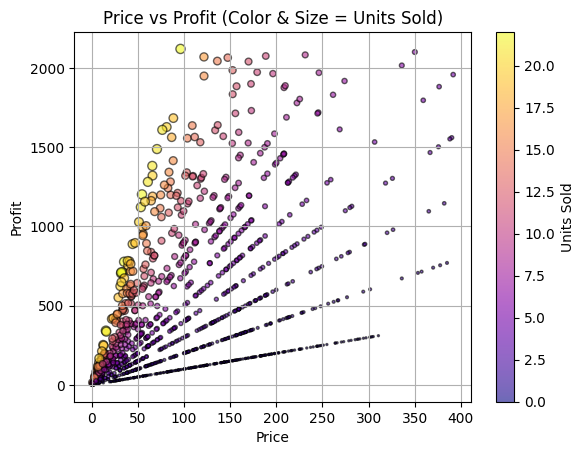

In [81]:
scatter = plt.scatter(df['price'], df['profit'],
                      c=df['sold'], s=df['sold']*2,
                      cmap='plasma', alpha=0.6, edgecolors='k')
plt.colorbar(scatter, label='Units Sold')
plt.xlabel('Price')
plt.ylabel('Profit')
plt.title('Price vs Profit (Color & Size = Units Sold)')
plt.grid(True)
plt.show()

# Insights :
# 1) Higher price → higher profit, but not always the max.
# 2) Low price + high units sold = high profit.
# 3) Items priced above ₹200 have low sales volume (small, dull circles).

Text(0.5, 1.0, 'Category-wise count')

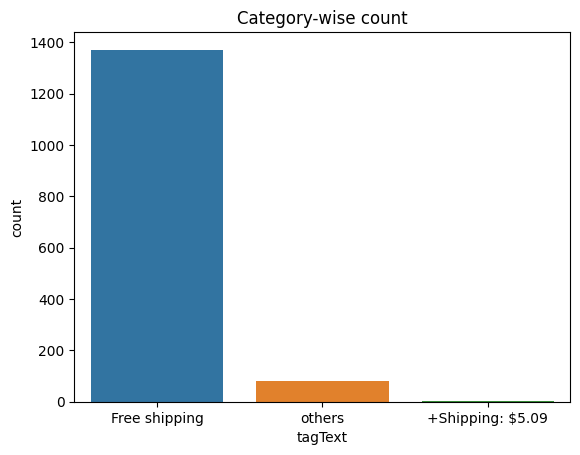

In [82]:
sns.countplot(x='tagText',data=df, hue='tagText')
plt.title('Category-wise count')

# Insights :
# 1) Free shipping dominates — most listings offer it.
# 2) Others are very few.
# 3) Paid shipping (+$5.09) is rare.

# 💡 Note: Free shipping likely boosts buyer interest and sales.

Text(0.5, 1.0, 'Top 3 Most Sold Products')

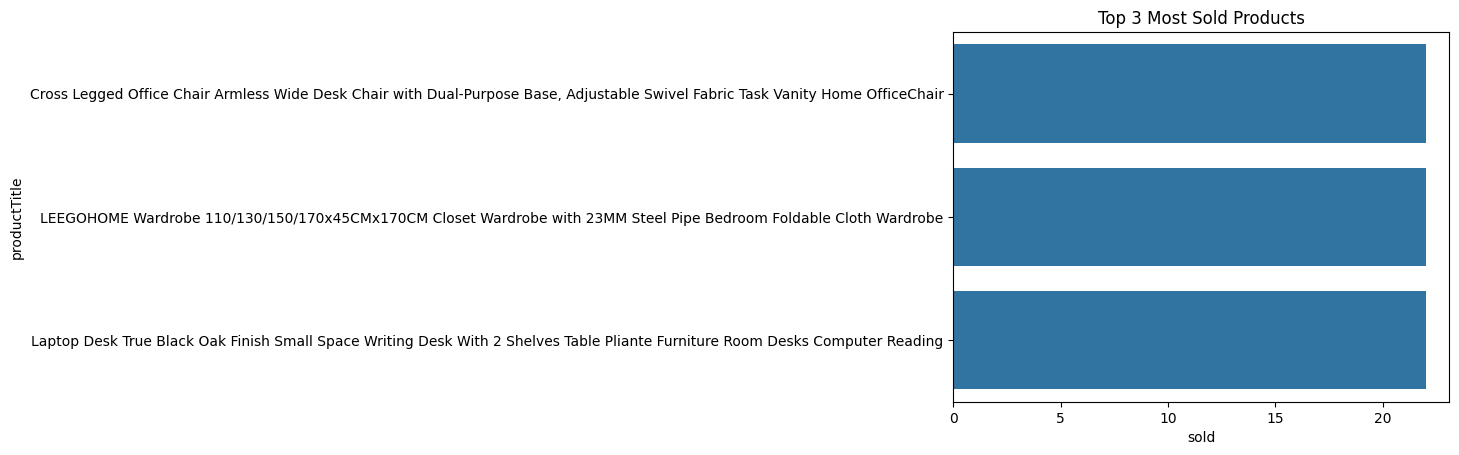

In [83]:
top_products = df.sort_values('sold', ascending=False).head(3)
sns.barplot(y='productTitle', x='sold', data=top_products)
plt.title('Top 3 Most Sold Products')

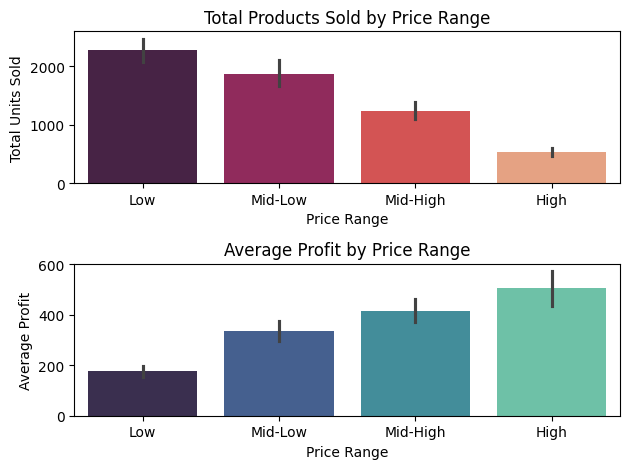

In [84]:
plt.subplot(2,1,1)
sns.barplot(x='price_range', y='sold', data=df, estimator=sum, palette='rocket', hue='price_range')
plt.title('Total Products Sold by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Total Units Sold')

plt.subplot(2,1,2)
sns.barplot(x='price_range', y='profit', data=df, estimator='mean', palette='mako', hue='price_range')
plt.title('Average Profit by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Average Profit')

plt.tight_layout()
plt.show()

# Insights :
# 1) Customers prefer lower-priced products, resulting in much higher volume sales.
# 2) Higher-priced products generate higher profit margins, though they sell in lower volumes.
# Low-priced products → High sales volume, low profit per unit.
# High-priced products → Low sales volume, high profit per unit.

# | **Price Range** | **Units Sold** | **Average Profit** | **Insight**                         |
# | --------------- | -------------- | ------------------ | ----------------------------------- |
# | Low             | Highest        | Lowest             | Most preferred by customers         |
# | Mid-Low         | High           | Moderate           | Good balance of sales and profit    |
# | Mid-High        | Moderate       | High               | Lower sales, higher profit per unit |
# | High            | Lowest         | Highest            | High profit per item but least sold |


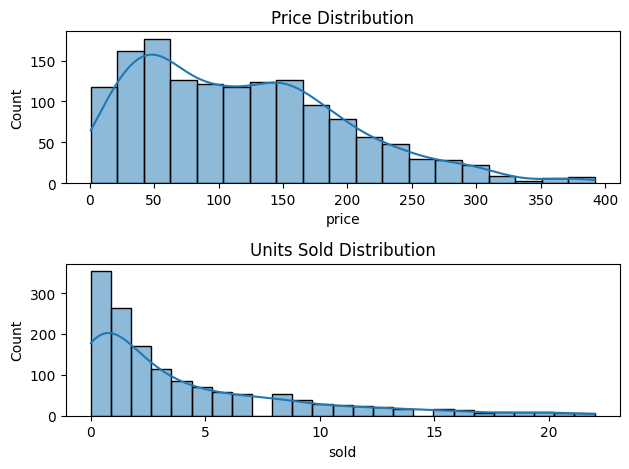

In [85]:
# Histogram
plt.subplot(2,1,1)
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')

plt.subplot(2,1,2)
sns.histplot(df['sold'], kde=True)
plt.title('Units Sold Distribution')

plt.tight_layout()
plt.show()

# Insights :
# 1) Price is right-skewed — most products are priced on the lower end (₹50–₹200).
# 2) Units sold is also right-skewed — most products sell 0–2 units.
# 3) Very few items sell more than 10 units, indicating low individual demand or high product variety.

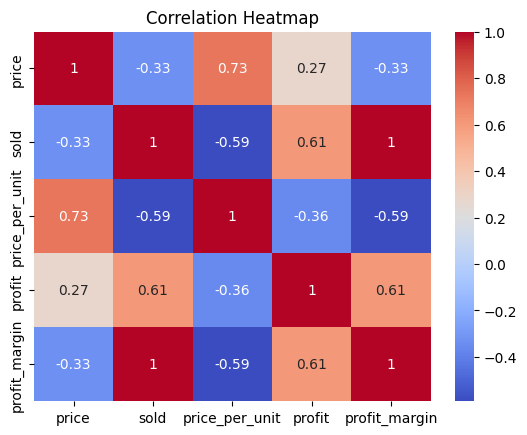

In [86]:
numeric_df = df.select_dtypes(include='number')
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Insights:
# 1) Sold ↔ Profit (0.61): More units sold → higher profit.
# 2) Sold ↔ Price/Unit (-0.59): Higher price → fewer sales (price-sensitive market).
# 3) Price/Unit ↔ Profit Margin (-0.59): Higher pricing may hurt margins due to lower sales or higher cost.

# Feature Engineering

In [87]:
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder instances
le_tag = LabelEncoder()
le_price = LabelEncoder()

# Apply Label Encoding
df['tagText_encoded'] = le_tag.fit_transform(df['tagText'].astype(str))
df['price_range_encoded'] = le_price.fit_transform(df['price_range'].astype(str))

# Optionally, drop the original columns
df.drop(['tagText', 'price_range'], axis=1, inplace=True)

In [88]:
from sklearn.preprocessing import StandardScaler

# Columns to normalize
cols_to_normalize = ['price', 'price_per_unit', 'profit', 'profit_margin']

# Initialize scaler
scaler = StandardScaler()

# Fit and transform
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])


# Model Selection & Training

In [89]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


In [90]:
# Define models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)


In [91]:
# Features and target
X = df.drop(columns=['productTitle','sold'])  # assuming 'sold' is the target column
y = df['sold']


In [92]:
# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [93]:
# Evaluation

# --- Linear Regression ---
lr_r2_scores = cross_val_score(lr, X, y, cv=kf, scoring='r2')
lr_preds = cross_val_predict(lr, X, y, cv=kf)
lr_rmse = mean_squared_error(y, lr_preds)

print("Linear Regression :")
print(f"Average R² Score: {np.mean(lr_r2_scores):.4f}")
print(f"RMSE: {lr_rmse:.4f}\n")

# --- Random Forest Regressor ---
rf_r2_scores = cross_val_score(rf, X, y, cv=kf, scoring='r2')
rf_preds = cross_val_predict(rf, X, y, cv=kf)
rf_rmse = mean_squared_error(y, rf_preds)

print("Random Forest Regressor :")
print(f"Average R² Score: {np.mean(rf_r2_scores):.4f}")
print(f"RMSE: {rf_rmse:.4f}")


Linear Regression :
Average R² Score: 1.0000
RMSE: 0.0000

Random Forest Regressor :
Average R² Score: 1.0000
RMSE: 0.0001


# Conclusion

1.   **Linear Regression Model Performance**
      
      *Average R² Score*: 1.0000

      *RMSE*: 0.0000

2.   **Random Forest Regressor Model Performance**
      
      *Average R² Score*: 1.0000

      *RMSE*: 0.0001


This indicates that the models are able to explain 100% of the variance in the target variable (sold). It suggests a good fit to the data.

The Root Mean Squared Error is close to zero, implying that the predictions made by the model are almost exactly matching the actual profit values.